In [1]:
from IPython.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>"))  # increase cell width
display(
    HTML("<style>div.output_area pre {white-space: pre;}</style>")
)  # horizontal scrolling instead of newlines for printed output
%reload_ext autoreload
%autoreload 2

In [2]:
import cirq
import cirq_superstaq as css
import ldpc
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import pymatching
import sinter
import stim
import stimcirq
from ldpc.sinter_decoders import SinterBeliefFindDecoder, SinterBpOsdDecoder

import qldpc

In [4]:
# [X,Z] gates don't contribute to [X, Z] basis SPAM

In [203]:
# Remove hadarmards, prep + meas ancilla in X basis
def gen_syndrome_surface_circuit(surface_code, sector = "X", repetitions=1):
    
    circuit = cirq.Circuit()
    stab_circuit = cirq.Circuit()

    if sector == "X":
        logicals = surface_code.get_logical_ops(qldpc.objects.Pauli.X)
        parity_matrix = surface_code.matrix_x
        offset = len(surface_code.matrix_z)
        
    else:
        logicals = surface_code.get_logical_ops(qldpc.objects.Pauli.Z)
        parity_matrix = surface_code.matrix_z
        offset = 0

    ancillas_x = [cirq.NamedQubit(f"ax{anc_idx}") for anc_idx in range(len(surface_code.matrix_x))]
    ancillas_z = [cirq.NamedQubit(f"az{anc_idx}") for anc_idx in range(len(surface_code.matrix_z))]

    # circuit for a single round of syndrome extraction

    stab_circuit = cirq.Circuit()

    for ancillas, matrix, gate in [(ancillas_z, surface_code.matrix_z, cirq.CZ), (ancillas_x, surface_code.matrix_x, cirq.CX)]:
        # stab_circuit += cirq.Moment(cirq.H.on_each(*ancillas))
        for anc, row in zip(ancillas, matrix):
            for bit_idx, bit in enumerate(row):
                if bit and gate == cirq.CX:
                    stab_circuit += cirq.Moment(gate(anc, cirq.LineQubit(bit_idx)))
        # stab_circuit += cirq.Moment(cirq.H.on_each(*ancillas))
        stab_circuit += cirq.Moment(stimcirq.MeasureAndOrResetGate(measure=True, reset=True, basis='X', invert_measure=False, key="").on_each(*ancillas))

    ancillas = ancillas_z + ancillas_x
    print(ancillas)
    data = cirq.LineQubit.range(surface_code.num_qubits)

    # Prepare States
    circuit = cirq.Moment([stimcirq.MeasureAndOrResetGate(measure=False, reset=True, basis=sector, invert_measure=False, key="").on(q) for q in data])
    circuit += cirq.Moment([stimcirq.MeasureAndOrResetGate(measure=False, reset=True, basis='X', invert_measure=False, key="").on(q) for q in ancillas])
    # circuit = moment
    
    # First round of stabilizer checks
    circuit += stab_circuit.copy()

    indices = [i - len(ancillas) for i, anc in enumerate(ancillas) if anc.name[:2] == f"a{sector.lower()}"]
    circuit += cirq.Moment([stimcirq.DetAnnotation(relative_keys=[x]) for x in indices])
    # Make this work for general code
    
    
    
    # Repeat Block
    circuit_op = stab_circuit.copy()
    circuit_op += cirq.Moment([stimcirq.DetAnnotation(relative_keys=[anc, anc-len(ancillas)]) for anc in range(-len(ancillas), 0)])
    # Make this work for general code
    circuit += cirq.Circuit(cirq.CircuitOperation(cirq.FrozenCircuit(circuit_op), repetitions=repetitions - 1, use_repetition_ids=False))
    
    # measure out data qubits
    for idx, d in enumerate(data):
        circuit += stimcirq.MeasureAndOrResetGate(measure=True, reset=False, basis=sector, invert_measure=False, key=idx).on(d)

    # compare data qubit measurements with parity measurements
    moment = []
    for anc_idx in range(len(parity_matrix)): # Make this work for general code
        data_indices = [idx - len(data) for idx, element in enumerate(parity_matrix[anc_idx]) if element == 1]
        moment.append(stimcirq.DetAnnotation(relative_keys=[anc_idx - len(circuit.all_qubits()) + offset] + data_indices, coordinate_metadata = (anc_idx, 1)))
    circuit += cirq.Moment(moment)

    # check logical observables
    for i, l in enumerate(logicals):
        observable_keys = [idx - len(data) for idx, element in enumerate(l) if element == 1]
        circuit += cirq.Moment(stimcirq.CumulativeObservableAnnotation(parity_keys=[], relative_keys=observable_keys, observable_index=i))    
    
    return circuit

In [10]:
class NoiseModel(cirq.NoiseModel):

    def __init__(self, error_prob):
        self.error_prob = error_prob

    def noisy_operation(self, operation: 'cirq.Operation') -> 'cirq.OP_TREE':
        if not operation.qubits:
            return operation
            
        if isinstance(operation.gate, stimcirq.MeasureAndOrResetGate):
            errors = [operation]
            if operation.gate.measure:
                if operation.gate.basis == "X":
                    spam = cirq.Z.with_probability(self.error_prob).on_each(*operation.qubits)
                else:
                    spam = cirq.X.with_probability(self.error_prob).on_each(*operation.qubits)
                errors = [spam] + errors
            if operation.gate.reset:
                if operation.gate.basis == "X":
                    spam = cirq.Z.with_probability(self.error_prob).on_each(*operation.qubits)
                else:
                    spam = cirq.X.with_probability(self.error_prob).on_each(*operation.qubits)
                errors += [spam]
            return errors
                

        if isinstance(operation, cirq.CircuitOperation):
            new_subcirc = operation.circuit.unfreeze().with_noise(self)
            return cirq.CircuitOperation(
                new_subcirc.freeze(),
                repetitions=operation.repetitions,
                repeat_until=operation.repeat_until,
                use_repetition_ids=operation.use_repetition_ids,
            )

        # if isinstance(operation.gate, cirq.MeasurementGate):
        #     print("here")
        #     # spam = cirq.X.with_probability(self.error_prob).on_each(*operation.qubits)
        #     spam = cirq.depolarize(self.error_prob, n_qubits = len(operation.qubits)).on(*operation.qubits)
        #     return [spam, operation, spam]
        return [operation, cirq.depolarize(self.error_prob, n_qubits = len(operation.qubits)).on(*operation.qubits)]
            

In [16]:
# from sympy.abc import x, y, z
# dims = {x: 12, y: 6}
# poly_a = x**3 + y + y**2
# poly_b = y**3 + x + x**2

# code = qldpc.codes.BBCode(dims, poly_a, poly_b)
noise_range = np.logspace(-5, -1.5, 10)
code_name = "Rotated Surface Code"
sector = "Z"
file_name = f"{('_'.join(code_name.split())).lower()}_{sector}"
# base_code = qldpc.codes.HammingCode(2)
# group = qldpc.abstract.CyclicGroup(4)
# code = qldpc.codes.QTCode.random(group, base_code, seed=0)
# # code = qldpc.codes.SurfaceCode(3, rotated=True)


# code_a = qldpc.codes.ClassicalCode.random(5, 3, seed=0)
# code_b = qldpc.codes.ClassicalCode.random(5, 3, seed=1)

# code = qldpc.codes.HGPCode(code_a, code_b)

def generate_example_tasks():
    for noise in noise_range:
        for d in [3, 5, 7]:
            print(d)
            code = qldpc.codes.SurfaceCode(d, rotated=True)
            circuit = gen_syndrome_surface_circuit(code, sector=sector, repetitions=d).with_noise(NoiseModel(noise))
            stim_circuit = stimcirq.cirq_circuit_to_stim_circuit(circuit)
            # print(circuit)
            yield sinter.Task(
                circuit=stim_circuit,
                detector_error_model=stim_circuit.detector_error_model(decompose_errors=False),
                json_metadata={'noise': noise, 'd': d, 'repetitions': d },
            )


def run_simulation(overwrite=True):

    filename = f'bposd_{file_name}.csv'
    
    if overwrite:
        if pathlib.Path(filename).is_file():
            pathlib.Path(filename).unlink()

    samples = sinter.collect(
        num_workers=10,
        max_shots=10_000,
        max_errors=100,
        tasks=generate_example_tasks(),
        # decoders=["pymatching"],
        decoders=['bposd'],
        custom_decoders={'bposd': SinterBpOsdDecoder(
            max_iter=5,
            bp_method="ms",
            ms_scaling_factor=0.625,
            schedule="parallel",
            osd_method="osd0")
        },

        print_progress=True,
        save_resume_filepath=filename,
    )
    return(samples)

In [17]:
samples = run_simulation()
samples

Starting 10 workers...


3
With Stim Syndrom Extraction
ax1 ax2
5
With Stim Syndrom Extraction
ax2 ax3
ax8 ax9
7
With Stim Syndrom Extraction
ax3 ax4
ax11 ax12
ax19 ax20


Finding work...


3
With Stim Syndrom Extraction
ax1 ax2
5
With Stim Syndrom Extraction
ax2 ax3
ax8 ax9
7
With Stim Syndrom Extraction
ax3 ax4
ax11 ax12
ax19 ax20
3
With Stim Syndrom Extraction
ax1 ax2
5
With Stim Syndrom Extraction
ax2 ax3
ax8 ax9
7
With Stim Syndrom Extraction


Running...
    bposd processes=1  ~core_mins_left=None    shots_left=10000    errors_left=100     {d=3,noise=1e-05,repetitions=3}
    bposd processes=1  ~core_mins_left=None    shots_left=10000    errors_left=100     {d=5,noise=1e-05,repetitions=5}
    bposd processes=1  ~core_mins_left=None    shots_left=10000    errors_left=100     {d=7,noise=1e-05,repetitions=7}
    bposd processes=1  ~core_mins_left=None    shots_left=10000    errors_left=100     {d=3,noise=2.4484367468222292e-05,repetitions=3}
    bposd processes=1  ~core_mins_left=None    shots_left=10000    errors_left=100     {d=5,noise=2.4484367468222292e-05,repetitions=5}
    bposd processes=1  ~core_mins_left=None    shots_left=10000    errors_left=100     {d=7,noise=2.4484367468222292e-05,repetitions=7}
    bposd processes=1  ~core_mins_left=None    shots_left=10000    errors_left=100     {d=3,noise=5.994842503189409e-05,repetitions=3}
    bposd processes=1  ~core_mins_left=None    shots_left=10000    errors_left=100     {d

ax3 ax4
ax11 ax12
ax19 ax20
3
With Stim Syndrom Extraction
ax1 ax2


Running...
    bposd processes=4  ~core_mins_left=1       shots_left=6400     errors_left=100     {d=7,noise=1e-05,repetitions=7}
    bposd processes=4  ~core_mins_left=1       shots_left=9700     errors_left=100     {d=7,noise=2.4484367468222292e-05,repetitions=7}
    bposd processes=2  ~core_mins_left=1       shots_left=9900     errors_left=100     {d=3,noise=5.994842503189409e-05,repetitions=3}
    bposd processes=0  ~core_mins_left=1       shots_left=9900     errors_left=100     {d=5,noise=5.994842503189409e-05,repetitions=5}
    bposd processes=0  ~core_mins_left=1       shots_left=9900     errors_left=100     {d=7,noise=5.994842503189409e-05,repetitions=7}
    bposd processes=0  ~core_mins_left=1       shots_left=9900     errors_left=100     {d=3,noise=0.00014677992676220705,repetitions=3}
Running...
    bposd processes=1  ~core_mins_left=1       shots_left=3200     errors_left=100     {d=7,noise=1e-05,repetitions=7}
    bposd processes=2  ~core_mins_left=1       shots_left=5000 

5
With Stim Syndrom Extraction
ax2 ax3
ax8 ax9
7
With Stim Syndrom Extraction
ax3 ax4
ax11 ax12
ax19 ax20
3
With Stim Syndrom Extraction
ax1 ax2
5
With Stim Syndrom Extraction
ax2 ax3
ax8 ax9


Running...
    bposd processes=4  ~core_mins_left=1       shots_left=6400     errors_left=100     {d=7,noise=5.994842503189409e-05,repetitions=7}
    bposd processes=4  ~core_mins_left=1       shots_left=8400     errors_left=100     {d=5,noise=0.00014677992676220705,repetitions=5}
    bposd processes=2  ~core_mins_left=1       shots_left=9900     errors_left=100     {d=7,noise=0.00014677992676220705,repetitions=7}
    bposd processes=0  ~core_mins_left=1       shots_left=7300     errors_left=100     {d=3,noise=0.00035938136638046257,repetitions=3}
    bposd processes=0  ~core_mins_left=1       shots_left=9900     errors_left=100     {d=5,noise=0.00035938136638046257,repetitions=5}


7
With Stim Syndrom Extraction


Running...
    bposd processes=2  ~core_mins_left=1       shots_left=4400     errors_left=100     {d=7,noise=5.994842503189409e-05,repetitions=7}
    bposd processes=4  ~core_mins_left=1       shots_left=9400     errors_left=100     {d=7,noise=0.00014677992676220705,repetitions=7}
    bposd processes=4  ~core_mins_left=1       shots_left=9500     errors_left=100     {d=5,noise=0.00035938136638046257,repetitions=5}


ax3 ax4
ax11 ax12
ax19 ax20
3
With Stim Syndrom Extraction
ax1 ax2
5
With Stim Syndrom Extraction
ax2 ax3
ax8 ax9
7
With Stim Syndrom Extraction
ax3 ax4
ax11 ax12
ax19 ax20


Running...
    bposd processes=2  ~core_mins_left=1       shots_left=6400     errors_left=100     {d=7,noise=0.00014677992676220705,repetitions=7}
    bposd processes=3  ~core_mins_left=1       shots_left=9900     errors_left=100     {d=7,noise=0.00035938136638046257,repetitions=7}
    bposd processes=3  ~core_mins_left=1       shots_left=9400     errors_left=100     {d=5,noise=0.0008799225435691075,repetitions=5}
    bposd processes=1  ~core_mins_left=None    shots_left=10000    errors_left=100     {d=7,noise=0.0008799225435691075,repetitions=7}
    bposd processes=1  ~core_mins_left=None    shots_left=10000    errors_left=100     {d=3,noise=0.0021544346900318843,repetitions=3}


3
With Stim Syndrom Extraction
ax1 ax2


Running...
    bposd processes=2  ~core_mins_left=1       shots_left=6400     errors_left=100     {d=7,noise=0.00014677992676220705,repetitions=7}
    bposd processes=5  ~core_mins_left=1       shots_left=8800     errors_left=100     {d=7,noise=0.00035938136638046257,repetitions=7}
    bposd processes=1  ~core_mins_left=1       shots_left=4800     errors_left=100     {d=5,noise=0.0008799225435691075,repetitions=5}
    bposd processes=2  ~core_mins_left=1       shots_left=9900     errors_left=100     {d=7,noise=0.0008799225435691075,repetitions=7}
    bposd processes=0  ~core_mins_left=1       shots_left=9900     errors_left=100     {d=3,noise=0.0021544346900318843,repetitions=3}
Running...
    bposd processes=1  ~core_mins_left=1       shots_left=4000     errors_left=100     {d=7,noise=0.00014677992676220705,repetitions=7}
    bposd processes=5  ~core_mins_left=1       shots_left=7600     errors_left=100     {d=7,noise=0.00035938136638046257,repetitions=7}
    bposd processes=1  ~core_

5
With Stim Syndrom Extraction
ax2 ax3
ax8 ax9
7
With Stim Syndrom Extraction


Running...
    bposd processes=3  ~core_mins_left=1       shots_left=6000     errors_left=100     {d=7,noise=0.00035938136638046257,repetitions=7}
    bposd processes=4  ~core_mins_left=1       shots_left=9400     errors_left=100     {d=7,noise=0.0008799225435691075,repetitions=7}
    bposd processes=2  ~core_mins_left=1       shots_left=6000     errors_left=90      {d=3,noise=0.0021544346900318843,repetitions=3}
    bposd processes=1  ~core_mins_left=None    shots_left=10000    errors_left=100     {d=5,noise=0.0021544346900318843,repetitions=5}


ax3 ax4
ax11 ax12
ax19 ax20
3
With Stim Syndrom Extraction
ax1 ax2
5
With Stim Syndrom Extraction
ax2 ax3
ax8 ax9


Running...
    bposd processes=2  ~core_mins_left=1       shots_left=4800     errors_left=100     {d=7,noise=0.00035938136638046257,repetitions=7}
    bposd processes=5  ~core_mins_left=1       shots_left=8600     errors_left=100     {d=7,noise=0.0008799225435691075,repetitions=7}
    bposd processes=3  ~core_mins_left=1       shots_left=9500     errors_left=100     {d=5,noise=0.0021544346900318843,repetitions=5}
    bposd processes=0  ~core_mins_left=1       shots_left=9900     errors_left=100     {d=7,noise=0.0021544346900318843,repetitions=7}
    bposd processes=0  ~core_mins_left=1       shots_left=9900     errors_left=98      {d=3,noise=0.00527499706370262,repetitions=3}
    bposd processes=0  ~core_mins_left=1       shots_left=9900     errors_left=100     {d=5,noise=0.00527499706370262,repetitions=5}
Running...
    bposd processes=4  ~core_mins_left=1       shots_left=6400     errors_left=100     {d=7,noise=0.0008799225435691075,repetitions=7}
    bposd processes=3  ~core_mins_le

7
With Stim Syndrom Extraction
ax3 ax4
ax11 ax12
ax19 ax20
3
With Stim Syndrom Extraction
ax1 ax2


Running...
    bposd processes=6  ~core_mins_left=1       shots_left=7600     errors_left=99      {d=7,noise=0.0021544346900318843,repetitions=7}
    bposd processes=1  ~core_mins_left=1       shots_left=3600     errors_left=54      {d=5,noise=0.00527499706370262,repetitions=5}
    bposd processes=1  ~core_mins_left=None    shots_left=10000    errors_left=100     {d=7,noise=0.00527499706370262,repetitions=7}
    bposd processes=2  ~core_mins_left=1       shots_left=9100     errors_left=46      {d=3,noise=0.01291549665014884,repetitions=3}


5
With Stim Syndrom Extraction
ax2 ax3
ax8 ax9
7
With Stim Syndrom Extraction
ax3 ax4
ax11 ax12
ax19 ax20
3
With Stim Syndrom Extraction
ax1 ax2
5
With Stim Syndrom Extraction
ax2 ax3
ax8 ax9
7
With Stim Syndrom Extraction
ax3 ax4
ax11 ax12
ax19 ax20


Running...
    bposd processes=2  ~core_mins_left=1       shots_left=5200     errors_left=99      {d=7,noise=0.0021544346900318843,repetitions=7}
    bposd processes=1  ~core_mins_left=1       shots_left=3600     errors_left=54      {d=5,noise=0.00527499706370262,repetitions=5}
    bposd processes=3  ~core_mins_left=2       shots_left=9900     errors_left=100     {d=7,noise=0.00527499706370262,repetitions=7}
    bposd processes=2  ~core_mins_left=1       shots_left=9900     errors_left=89      {d=5,noise=0.01291549665014884,repetitions=5}
    bposd processes=1  ~core_mins_left=None    shots_left=10000    errors_left=100     {d=7,noise=0.01291549665014884,repetitions=7}
    bposd processes=0  ~core_mins_left=1       shots_left=9900     errors_left=80      {d=3,noise=0.03162277660168379,repetitions=3}
    bposd processes=0  ~core_mins_left=1       shots_left=9900     errors_left=59      {d=5,noise=0.03162277660168379,repetitions=5}
    bposd processes=1  ~core_mins_left=None    shots_lef

[sinter.TaskStats(strong_id='f2b4344dfe4e1af99205904cb797adb35c618d5796640f3f25affdb08e5be68b', decoder='bposd', json_metadata={'noise': 1e-05, 'd': 3, 'repetitions': 3}, shots=10000, seconds=0.5619837980048032),
 sinter.TaskStats(strong_id='a86653d015f5800e91a06a9a633c811282ba95b3ae33f8a56a96af1fae25d49b', decoder='bposd', json_metadata={'noise': 2.4484367468222292e-05, 'd': 3, 'repetitions': 3}, shots=10000, seconds=0.5148823610070394),
 sinter.TaskStats(strong_id='e04b87784eadd1f034360e6d9d4a95692bd47e19e7952c25d803ff0f8eaa8d2b', decoder='bposd', json_metadata={'noise': 1e-05, 'd': 5, 'repetitions': 5}, shots=10000, seconds=1.9478673050107318),
 sinter.TaskStats(strong_id='5a4c080a9cb39a21ab6c10db51619009aafddfe0c003af1e5872a4bf8cbc1685', decoder='bposd', json_metadata={'noise': 2.4484367468222292e-05, 'd': 5, 'repetitions': 5}, shots=10000, seconds=1.916741982990061),
 sinter.TaskStats(strong_id='294d16b86d2cbe08327846eef3b09a356aa0d0fbd140722115d2d1c36fcc993c', decoder='bposd', js

In [18]:
def print_results(samples):
 # Print samples as CSV data.
    print(sinter.CSV_HEADER)
    for sample in samples:
        print(sample.to_csv_line())

def plot_results(samples):
    # Render a matplotlib plot of the data.
    fig, axis = plt.subplots(1, 1, sharey=True, figsize=(8, 6))
    sinter.plot_error_rate(
        ax=axis,
        stats=samples,
        group_func=lambda stat: f"{code_name} d={stat.json_metadata['d']}",
        filter_func=lambda stat: stat.decoder == 'bposd',
        # filter_func=lambda stat: stat.decoder == "pymatching",
        x_func=lambda stat: stat.json_metadata['noise'],
    )

    axis.set_ylabel('Logical Error Rate')
    axis.set_title(f'{code_name} threshold with BPOSD for {sector} stabilizers')

    axis.plot(noise_range, noise_range, "--", color="k")
    axis.loglog()
    axis.grid()
    axis.set_xlabel('Physical Error Rate')
    axis.legend()

    # Save to file and also open in a window.
    fig.savefig(f'{file_name}_plot.png')
    plt.show()

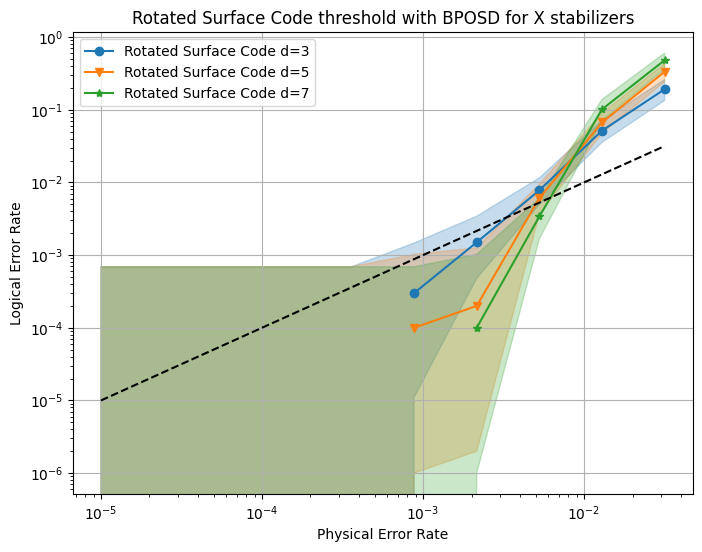

In [14]:
plot_results(samples)

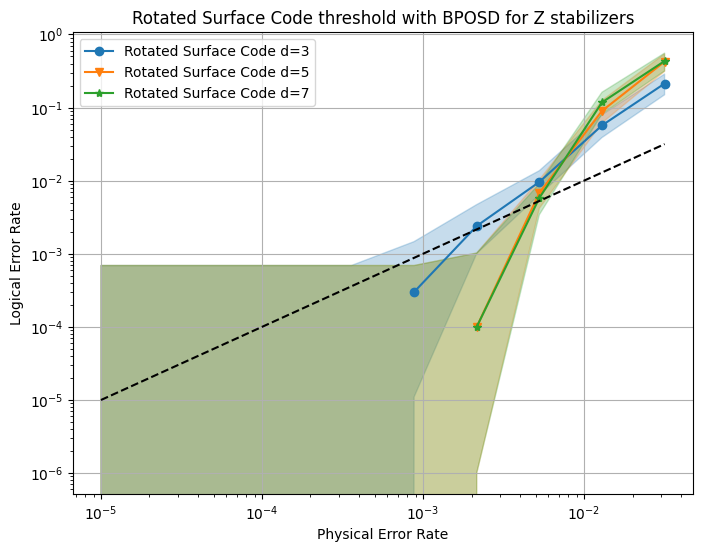

In [19]:
plot_results(samples)

# Currently Debugging

In [6]:
# Remove hadarmards, prep + meas ancilla in X basis
def gen_syndrome_surface_circuit(surface_code, sector = "X", repetitions=1):
    print("With Stim Syndrom Extraction")
    
    circuit = cirq.Circuit()
    stab_circuit = cirq.Circuit()

    if sector == "X":
        logicals = surface_code.get_logical_ops(qldpc.objects.Pauli.X)
        parity_matrix = surface_code.matrix_x
        offset = len(surface_code.matrix_z)
        
    else:
        logicals = surface_code.get_logical_ops(qldpc.objects.Pauli.Z)
        parity_matrix = surface_code.matrix_z
        offset = 0

    ancillas_x = [cirq.NamedQubit(f"ax{anc_idx}") for anc_idx in range(len(surface_code.matrix_x))]
    ancillas_z = [cirq.NamedQubit(f"az{anc_idx}") for anc_idx in range(len(surface_code.matrix_z))]

    # circuit for a single round of syndrome extraction

    stabilizers = {}
    for a, row in zip(ancillas_z, surface_code.matrix_z):
        stabs = [cirq.CZ(a, cirq.LineQubit(i)) for i , element in enumerate(row) if element == 1]
        if len(stabs) == 4:
            order = [3, 2, 1, 0]
        else:
            order = [1, 0]
    
        stabilizers[a] = [stab for idx, stab in sorted(zip(order, stabs))]
    
    for a, row in zip(ancillas_x, surface_code.matrix_x):
        stabs = [cirq.CX(a, cirq.LineQubit(i)) for i , element in enumerate(row) if element == 1]
        if len(stabs) == 4:
            order = [3, 1, 2, 0]
        else:
            order = [1, 0]
    
        stabilizers[a] = [stab for idx, stab in sorted(zip(order, stabs))]
    
    final_stabilizers = []
    for stabs in stabilizers.values():
        if len(stabs) == 4:
            final_stabilizers.append(stabs)
    
    it = iter([anc for anc in ancillas_x if len(stabilizers[anc]) == 2])
    for a, b in zip(it, it):
        print(a, b)
        final_stabilizers.append(stabilizers[b] + stabilizers[a])
    
    half_stabs = [anc for anc in ancillas_z if len(stabilizers[anc]) == 2]
    half = len(half_stabs)
    for a, b in zip(half_stabs[:half], half_stabs[half:]):
        print(a, b)
        final_stabilizers.append(stabilizers[a] + stabilizers[b])
    # final_stabilizers.append(stabilizers[ancillas_z[0]] + stabilizers[ancillas_z[3]])
    # final_stabilizers.append(stabilizers[ancillas_x[2]] + stabilizers[ancillas_x[1]])
    
    final_stabilizers = np.array(final_stabilizers)
    for i in range(final_stabilizers.shape[1]):
        # print(*final_stabilizers[:, i])
        stab_circuit += cirq.Moment(final_stabilizers[:, i])
    

    ancillas = ancillas_z + ancillas_x
    data = cirq.LineQubit.range(surface_code.num_qubits)

    stab_circuit += cirq.Moment(stimcirq.MeasureAndOrResetGate(measure=True, reset=True, basis='X', invert_measure=False, key="").on_each(*ancillas))

    # Prepare States
    circuit = cirq.Moment([stimcirq.MeasureAndOrResetGate(measure=False, reset=True, basis=sector, invert_measure=False, key="").on(q) for q in data])
    circuit += cirq.Moment([stimcirq.MeasureAndOrResetGate(measure=False, reset=True, basis='X', invert_measure=False, key="").on(q) for q in ancillas])
    # circuit = moment
    
    # First round of stabilizer checks
    circuit += stab_circuit.copy()

    indices = [i - len(ancillas) for i, anc in enumerate(ancillas) if anc.name[:2] == f"a{sector.lower()}"]
    circuit += cirq.Moment([stimcirq.DetAnnotation(relative_keys=[x]) for x in indices])
    # Make this work for general code
    
    
    
    # Repeat Block
    circuit_op = stab_circuit.copy()
    circuit_op += cirq.Moment([stimcirq.DetAnnotation(relative_keys=[anc, anc-len(ancillas)]) for anc in range(-len(ancillas), 0)])
    # Make this work for general code
    circuit += cirq.Circuit(cirq.CircuitOperation(cirq.FrozenCircuit(circuit_op), repetitions=repetitions - 1, use_repetition_ids=False))
    
    # measure out data qubits
    for idx, d in enumerate(data):
        circuit += stimcirq.MeasureAndOrResetGate(measure=True, reset=False, basis=sector, invert_measure=False, key=idx).on(d)

    # compare data qubit measurements with parity measurements
    moment = []
    for anc_idx in range(len(parity_matrix)): # Make this work for general code
        data_indices = [idx - len(data) for idx, element in enumerate(parity_matrix[anc_idx]) if element == 1]
        moment.append(stimcirq.DetAnnotation(relative_keys=[anc_idx - len(circuit.all_qubits()) + offset] + data_indices, coordinate_metadata = (anc_idx, 1)))
    circuit += cirq.Moment(moment)

    # check logical observables
    for i, l in enumerate(logicals):
        observable_keys = [idx - len(data) for idx, element in enumerate(l) if element == 1]
        circuit += cirq.Moment(stimcirq.CumulativeObservableAnnotation(parity_keys=[], relative_keys=observable_keys, observable_index=i))    
    
    return circuit

# Archive

In [3]:
def count_logical_errors(circuit: stim.Circuit, num_shots: int, decompose_errors=True, ignore_decomposition_failures=False) -> int:
    # Sample the circuit.
    sampler = circuit.compile_detector_sampler()
    detection_events, observable_flips = sampler.sample(num_shots, separate_observables=True)

    # Configure a decoder using the circuit.
    detector_error_model = circuit.detector_error_model()
    matcher = pymatching.Matching.from_detector_error_model(detector_error_model)

    # Run the decoder.
    predictions = matcher.decode_batch(detection_events)

    # Count the mistakes.
    num_errors = 0
    for shot in range(num_shots):
        actual_for_shot = observable_flips[shot]
        predicted_for_shot = predictions[shot]
        if not np.array_equal(actual_for_shot, predicted_for_shot):
            num_errors += 1
    return num_errors